# Pseudo-code for a simple Decision Tree

```
func buildDecisionTree(X, y):
    # either reach max depth, min samples split, or pure class
    if stopping_condition() == true:   
        return create_leaf_node(class = most_common_class(y))
    best_impurity = infinity
    best_feature = null
    best_threshold = null
    for each feature in X:
        if feature is categorical:
            impurity = sum (weighted (gini)-impurity of each category)
            if impurity < best_impurity:
                best_impurity = impurity
                best_feature = feature
                best_threshold = null   # no threshold for categorical feature
        else:  # feature is numerical
            for each threshold in midpoint of adjacent values in sorted(feature):
                X_left, y_left = subset where feature < threshold
                X_right, y_right = subset where feature >= threshold
                impurity = sum(weighted (gini)-impurity of left and right subsets)
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_feature = feature
                    best_threshold = threshold
    node = DecisionNode(feature = best_feature, threshold = best_threshold)
    if best_feature is categorical:
        for each category in unique values of best_feature:
            X_subset =  X[best_feature] == category
            y_subset = y[best_feature] == category
            node.children[category] = buildDecisionTree(X_subset, y_subset)
    else:  # best_feature is numerical
        X_left = X[best_feature] < best_threshold
        X_right = X[best_feature] >= best_threshold
        y_left = y[best_feature] < best_threshold
        y_right = y[best_feature] >= best_threshold
        node.children["left"] = buildDecisionTree(X_left, y_left)
        node.children["right"] = buildDecisionTree(X_right, y_right)
```

# Decision Tree Algorithm Testing

In [ ]:
import pandas as pd
from main import handle_missing_values
from decision_tree import DecisionTree
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
train_data = handle_missing_values(train_data)
test_data = handle_missing_values(test_data)

### DT model with `max_depth=10`, `min_sample_split=20`, and `criterion='gini'` index

In [9]:
dt = DecisionTree(max_depth=10, 
                  min_samples_split=20, 
                  criterion='gini')
dt.fit(train_data.drop('income', axis=1), train_data['income'])
print("Train Accuracy:", 
      dt.evaluate(train_data.drop('income', axis=1), train_data['income']))
print("Test Accuracy:", 
      dt.evaluate(test_data.drop('income', axis=1), test_data['income']))
# Take about 1m10s to run

Train Accuracy: 0.8343109855348423
Test Accuracy: 0.8304772434125668


### DT model with `max_depth=10`, `min_sample_split=20`, and `criterion='entropy'` index

In [10]:
dt = DecisionTree(max_depth=10, 
                  min_samples_split=20, 
                  criterion='entropy')
dt.fit(train_data.drop('income', axis=1), train_data['income'])
print("Train Accuracy:", 
      dt.evaluate(train_data.drop('income', axis=1), train_data['income']))
print("Test Accuracy:", 
      dt.evaluate(test_data.drop('income', axis=1), test_data['income']))
# Take about 1m30s to run

Train Accuracy: 0.833881023310095
Test Accuracy: 0.8301701369694736


- Both criteria produce very similar results on both training and testing data.
- One reason that could explain why the results are so similar because the size of the dataset which is sufficiently large enough
- If training time matters, Gini usually slightly faster to compute than Entropy (because of log in Entropy)
- The very similar results also mean the data features and tree configuration (except criterion) dominate the model performance; criterion choice has minimal impact for this specific case.


### Accuracy against `min_sample_split` graph

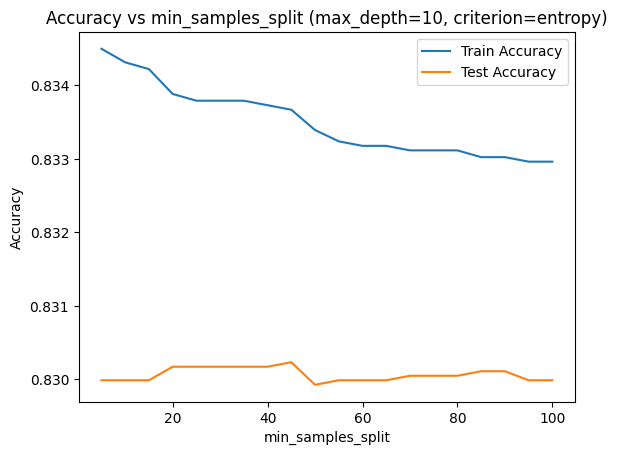

In [14]:
accuracy_dict = {}
for min_sample_split in range(5, 101, 5):
    dt = DecisionTree(max_depth=10, 
                      min_samples_split=min_sample_split, 
                      criterion='entropy')
    dt.fit(train_data.drop('income', axis=1), train_data['income'])
    train_accuracy = dt.evaluate(train_data.drop('income', axis=1), train_data['income'])
    test_accuracy = dt.evaluate(test_data.drop('income', axis=1), test_data['income'])
    accuracy_dict[min_sample_split] = [train_accuracy, test_accuracy]

import matplotlib.pyplot as plt
plt.plot(list(accuracy_dict.keys()), [v[0] for v in accuracy_dict.values()], 
         label='Train Accuracy')
plt.plot(list(accuracy_dict.keys()), [v[1] for v in accuracy_dict.values()], 
         label='Test Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs min_samples_split (max_depth=10, criterion=entropy)')
plt.legend()
plt.show()

- As `min_sample_split` increases, training accuracy slightly decrease. This is because larger minnimum spits prevent the tree from making more specific splits, reudcing overfitting to training data
- Test accuracy stays roughtly constant, with minor increase from 17 to 45 `min_sample_split`
- Overfitting is relatively significant with `min_sample_split` being less than 10
- Increase `min_sample_split` is a technique help control overfitting by requiring internal node to have more data before splitting

### Why training data accuracy is not 100%?

- There are many factors that can potentially contribut to why the accuracy of training data is not 100%
- Real-world data is messy. This could include overlap classes (same feature but different class), hardware/software/human makes error while collecting the data 
- The pattern of the data is more complex than the model, thus the model cannot perfectly seperate the patterns
- Sometimes all the available features still cannot explain all the variation in the target class.

**Is there a way to get 100% accuracy on training dataset?**

- We ca get 100% accuracy by overfitting the training data

**What parameters should you change to get a tree with perfect training accuracy?**

- Set `max_depth` to a very large value and `min_sample_split` to 1. This give the tree to grow as deep and complex as possible so it keeps splitting until each leaf node contains single class.

**How would that affect the accuracy of the test data?**

- The tree is essentially memorizing the training data, not learning the underlying patterns of the sample data
- It will likely perform poorly on new, unseen test data because it cannot generalize 

**Explain if such a classification model has a high variance or bias**

Such decision tree model (unrestricted decision tree) has:

- Low bias: the model fit the training data extremely well, making as few assumptions as possible can capture every subtle details of the training data
- High variance: such model is highly sensitive to small changes in the training data. E.g. If I provide different training samples or alter the data, the model's predictions and decisions can change dramatically.

### Accuracy against `min_sample_split` graph


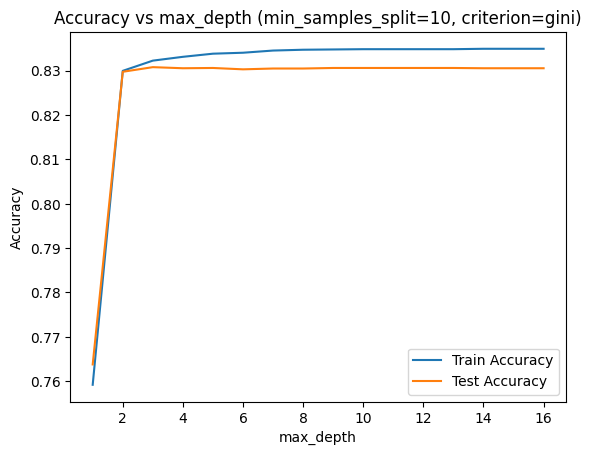

In [15]:
accuracy_dict = {}
for depth in range(1, 17):
    dt = DecisionTree(max_depth=depth, 
                      min_samples_split=10, 
                      criterion='gini')
    dt.fit(train_data.drop('income', axis=1), train_data['income'])
    train_accuracy = dt.evaluate(train_data.drop('income', axis=1), train_data['income'])
    test_accuracy = dt.evaluate(test_data.drop('income', axis=1), test_data['income'])
    accuracy_dict[depth] = [train_accuracy, test_accuracy]
import matplotlib.pyplot as plt
plt.plot(list(accuracy_dict.keys()), [v[0] for v in accuracy_dict.values()], 
         label='Train Accuracy')
plt.plot(list(accuracy_dict.keys()), [v[1] for v in accuracy_dict.values()], 
         label='Test Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_depth (min_samples_split=10, criterion=gini)')
plt.legend()
plt.show()

- Both training and testing accuracy improve significantly at `max_depth` equals 1 and 2
- With `max_depth > 2`, the accuracy of traing and testing sets diverse, with training accuracy slightly higher than test accuracy
- The gap between train and test accuracy is small, indicating minimal overfitting under these conditions
    - The reason why the gap between train and test accuracy being relatively small coule be because `min_sample_split` already prevent the tree to go any further despite the higher freedom in `max_depth`
- Increasing tree depth in general allows the model to capture more complex patterns, but after a certain point, additional complexity would give diminishing returns.
- Both lines grow at similar values suggests this tree generalize well for the current dataset and hyperparameters, without significant overfitting (or underfitting)